# Porto Seguro's Safe Driver Prediction
(In progress)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(10)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0,5,1,4,0,0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0,2,1,3,1,0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0,5,1,4,0,0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0,5,1,3,1,0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1,1,1,2,0,0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


In [4]:
print(train.shape[0])
print(test.shape[0])

595212
892816


## Target column

In [5]:
train['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

The proportion of people who filed a claim is way lower than those who didn't, we have to keep that in mind.

## Correlation matrix
Let's see the correlation matrix for some ordinal columns:

#### ps_calc columns

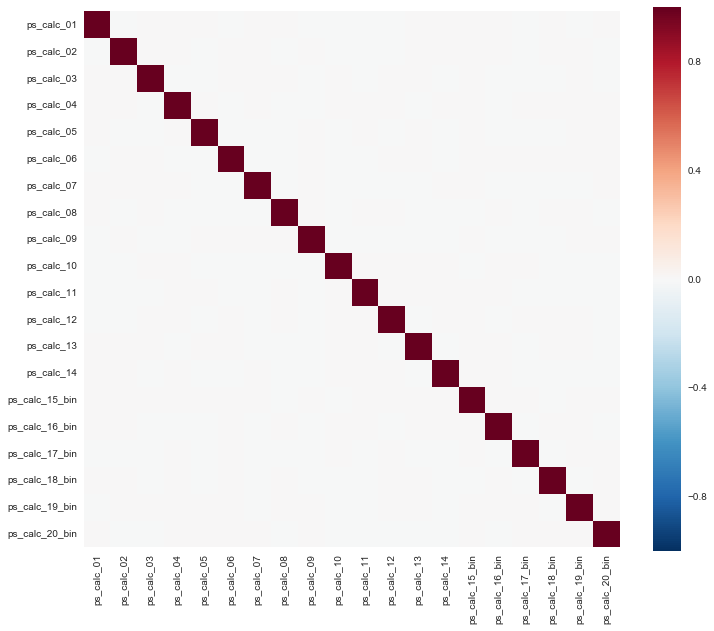

In [6]:
calc_cols = [col for col in train.columns if 'calc' in col]

fig = plt.figure(figsize=(12,10))
sns.heatmap(train[calc_cols].corr(), square=True)
plt.show()

It is clear that there is absolutely no correlation between any of the calc cols and the target variable. Deleting them would not hurt the model and would reduce dimentionality, so let's do it:

In [7]:
train.drop(calc_cols, axis=1, inplace=True)
test.drop(calc_cols, axis=1, inplace=True)

#### Other ordinal cols

In [8]:
ordinal_cols = [col for col in train.columns if 'cat' not in col and 'bin' not in col and 'calc' not in col]
ordinal_cols.remove('id')

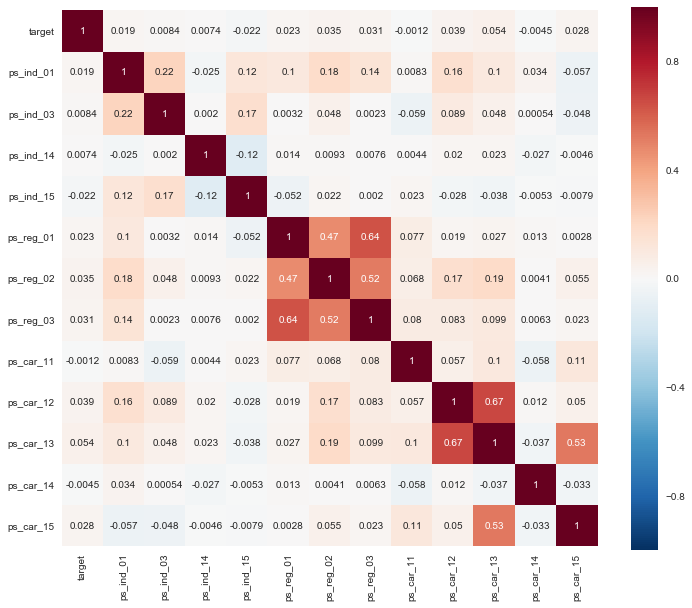

In [9]:
fig = plt.figure(figsize=(12,10))
sns.heatmap(train[ordinal_cols].corr(), annot=True, square=True)
plt.show()

We can see that no feature has even a slight correlation with the target, but some features are intercorrelated :
- `ps_car_12` with `ps_car_13`
- `ps_reg_01` with `ps_reg_02 with ps_reg_03`
- `ps_car_13` with `ps_car_15`

We have to keep this in mind.

## Missing Values
Values of -1 indicate that the value is missing.

In [10]:
for col in train.drop('target', axis=1).columns:
    train.replace({col: {-1:np.nan}}, inplace=True)
    test.replace({col: {-1:np.nan}}, inplace=True)

In [11]:
train.isnull().sum()

id                    0
target                0
ps_ind_01             0
ps_ind_02_cat       216
ps_ind_03             0
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_ind_06_bin         0
ps_ind_07_bin         0
ps_ind_08_bin         0
ps_ind_09_bin         0
ps_ind_10_bin         0
ps_ind_11_bin         0
ps_ind_12_bin         0
ps_ind_13_bin         0
ps_ind_14             0
ps_ind_15             0
ps_ind_16_bin         0
ps_ind_17_bin         0
ps_ind_18_bin         0
ps_reg_01             0
ps_reg_02             0
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_04_cat         0
ps_car_05_cat    266551
ps_car_06_cat         0
ps_car_07_cat     11489
ps_car_08_cat         0
ps_car_09_cat       569
ps_car_10_cat         0
ps_car_11_cat         0
ps_car_11             5
ps_car_12             1
ps_car_13             0
ps_car_14         42620
ps_car_15             0
dtype: int64

I'm going to delete every column that has more than 10% of missing values.

In [12]:
deleted_cols_nan = []

for col in train.drop('target', axis=1).columns:
    if train[col].isnull().sum() > 0.10*train.shape[0]:
        train.drop(col, axis=1, inplace=True)
        deleted_cols_nan.append(col)
        
test.drop(deleted_cols_nan, axis=1, inplace=True)

In [13]:
target_series = train['target']
train_len = train.shape[0]

combined = pd.concat([train.drop('target',axis=1),test])

### Filling missing values
### Categorical features
#### ps_ind_02_cat

In [14]:
combined['ps_ind_02_cat'].value_counts()

1.0    1079327
2.0     309747
3.0      70172
4.0      28259
Name: ps_ind_02_cat, dtype: int64

In [15]:
combined['ps_ind_02_cat'].fillna(1.0, inplace=True)

#### ps_ind_04_cat

In [16]:
combined['ps_ind_04_cat'].value_counts()

0.0    866864
1.0    620936
Name: ps_ind_04_cat, dtype: int64

In [17]:
combined['ps_ind_04_cat'].fillna(1.0, inplace=True)

#### ps_car_01_cat

In [18]:
combined['ps_car_01_cat'].value_counts()

11.0    518725
7.0     449617
6.0     155779
10.0    124587
4.0      65720
9.0      50501
5.0      45082
8.0      37603
3.0      16682
0.0      14844
2.0       5242
1.0       3379
Name: ps_car_01_cat, dtype: int64

In [19]:
combined['ps_car_01_cat'].fillna(11.0, inplace=True)

#### ps_car_02_cat

In [20]:
combined['ps_car_02_cat'].value_counts()

1.0    1234979
0.0     253039
Name: ps_car_02_cat, dtype: int64

In [21]:
combined['ps_car_02_cat'].fillna(1.0, inplace=True)

#### ps_car_09_cat

In [22]:
combined['ps_car_09_cat'].value_counts()

2.0    883326
0.0    486510
1.0     72947
3.0     36798
4.0      7001
Name: ps_car_09_cat, dtype: int64

In [23]:
combined['ps_car_09_cat'].fillna(2.0, inplace=True)

#### ps_ind_05_cat

In [24]:
combined['ps_ind_05_cat'].value_counts()

0.0    1319412
6.0      51877
4.0      45706
3.0      20754
1.0      20737
2.0      10707
5.0       4316
Name: ps_ind_05_cat, dtype: int64

In [25]:
combined['ps_ind_05_cat'].fillna(0.0, inplace=True)

#### ps_car_07_cat

In [26]:
combined['ps_car_07_cat'].value_counts()

1.0    1383070
0.0      76138
Name: ps_car_07_cat, dtype: int64

In [27]:
combined['ps_car_07_cat'].fillna(1.0, inplace=True)

### Continuous/ordinal features
#### ps_car_11

In [28]:
combined['ps_car_11'].value_counts()

3.0    797388
2.0    473339
1.0    152661
0.0     64634
Name: ps_car_11, dtype: int64

In [29]:
combined['ps_car_11'].fillna(3.0, inplace=True)

#### ps_car_12

In [30]:
combined['ps_car_12'].describe()

count    1.488027e+06
mean     3.799528e-01
std      5.835093e-02
min      1.000000e-01
25%      3.162278e-01
50%      3.741657e-01
75%      4.000000e-01
max      1.264911e+00
Name: ps_car_12, dtype: float64

In [31]:
combined['ps_car_12'].fillna(0.3799, inplace=True)

#### ps_car_14
We have a lot of missing values for this one, let's try to be clever choosing which value(s) to replace with:

In [32]:
combined['ps_car_14'].describe()

count    1.381603e+06
mean     3.746796e-01
std      4.562060e-02
min      1.095445e-01
25%      3.504283e-01
50%      3.734970e-01
75%      3.977436e-01
max      6.363961e-01
Name: ps_car_14, dtype: float64

In [33]:
train_temp = combined.iloc[:train_len]
train_temp['target'] = target_series

In [34]:
is_0 = train_temp[train_temp['target'] == 0]
is_1 = train_temp[train_temp['target'] == 1]

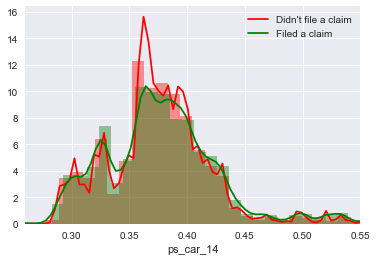

In [35]:
sns.distplot(is_0['ps_car_14'].dropna(),color='r', kde_kws={"color": "r", "label": "Didn't file a claim"})
sns.distplot(is_1['ps_car_14'].dropna(),color='g', kde_kws={"color": "g", "label": "Filed a claim"})
plt.xlim(0.26,0.55)
plt.show()

This graph shows that there are no big differences in distributions for the `ps_car_14` feature whether the client filed a claim or didn't. 
Also, the range of the values is quite small, so I think it would be better to get rid of this feature.

In [36]:
combined.drop('ps_car_14', axis=1, inplace=True)

In [37]:
combined.isnull().sum().sum()

0

No more missing values!

### Dummy coding of cat features

In [38]:
cat_cols = [col for col in train.columns if 'cat' in col]

for col in cat_cols:
    temp = pd.get_dummies(combined[col])
    combined = pd.concat([combined,temp], axis=1)
    combined = combined.drop(col, axis=1)

In [54]:
combined.shape

(1488028, 193)

## Stacking

In [75]:
from sklearn.model_selection import StratifiedKFold

class Ensemble:
    def __init__(self, n_splits, models, stacker):
        self.n_splits = n_splits
        self.models = models
        self.stacker = stacker
        
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        sKFold = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1000)
        folds = list(sKFold.split(X,y))
        
        S_train = np.zeros((X.shape[0],len(self.models)))
        S_test = np.zeros((T.shape[0],len(self.models)))
        
        for i, model in enumerate(self.models):
            # on va predict TOUT le test set avec chaque fold du training set
            # puis ensuite on va faire la moyenne de chaque prediction qu'on stocke dans S_test 
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            
            for j, (train_index,test_index) in enumerate(folds):
                X_train = X[train_index]
                y_train = y[train_index]
                X_test = X[test_index]
                y_test = y[test_index]
                
                print('Fit %s fold %d' %(str(model).split('(')[0],j+1))
                model.fit(X_train,y_train)
                y_pred = model.predict_proba(X_test)[:,1]
                
                S_train[test_index, i] = y_pred
                S_test_i[:, j] = model.predict_proba(T)[:,1]
                
            S_test[:, i] = S_test_i.mean(axis=1)
                
            results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

## Splitting train and test datasets

In [76]:
train = combined.iloc[:train_len]
test = combined.iloc[train_len:]
#train['target'] = target_series
train_features = train.drop(['id','target'], axis=1)
test_features = test.drop(['id'], axis=1)

## Models

### Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

features = train.drop(['id','target'], axis=1).columns
target = 'target'

kf = KFold(8, shuffle=True, random_state = 1)

#rf = RandomForestClassifier(min_samples_split=50)
#res = cross_val_score(rf, train[features], train[target], scoring='roc_auc', cv=kf)
#res


### LightGBM

In [78]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

model_lgb = lgb.LGBMClassifier(n_estimators = 180, boosting = 'gbdt', objective = 'binary', seed=99)
model_lgb2 = lgb.LGBMClassifier(n_estimators = 100, max_depth = 5, boosting = 'gbdt', objective = 'binary', seed=99, min_child_samples=500)
log = LogisticRegression()
res = cross_val_score(model_lgb, train_features, target_series, scoring='roc_auc', cv=kf)
res.mean()

0.63947995707780714

In [1]:
#stack = Ensemble(n_splits = 3, models = [model_lgb,model_lgb2, xgb], stacker = log)

#y_pred = stack.fit_predict(train_features, target_series, test_features)

In [ ]:
res = cross_val_score(log, train[features], train[target], scoring='roc_auc', cv=kf)
res.mean()

In [73]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eta=0.02, max_depth=4, subsample=0.9, colsample_bytree=0.9, objective='binary:logistic', eval_metric='auc', silent=True)
#res = cross_val_score(xgb, train[features], train[target], scoring='roc_auc', cv=kf)
#res.mean()

In [ ]:
0.6364

## Submission

In [43]:
xgb.fit(train[features], train[target])
probas = xgb.predict_proba(test[features])

In [44]:
probas

array([[ 0.97154498,  0.02845502],
       [ 0.97147506,  0.02852496],
       [ 0.97213274,  0.02786724],
       ..., 
       [ 0.95468396,  0.04531604],
       [ 0.97515076,  0.02484924],
       [ 0.96957862,  0.0304214 ]], dtype=float32)

In [50]:
sub = pd.DataFrame({'id' :test['id'],'target': probas[:,1]})

In [51]:
sub.to_csv('sub5.csv', index=False)

## Evaluating the Gini score

In [51]:
train2 = train.iloc[:int(0.6*train.shape[0])]
test2 = train.iloc[int(0.6*train.shape[0]):]

In [52]:
def eval_gini(y_true, y_prob):
    """
    Original author CPMP : https://www.kaggle.com/cpmpml
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [ ]:
eval_gini(test2[target],probas)